<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/SampleModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is this notebook?
This is a notebook to load a few audio files and load the VGGish model. The idea is to make sure the model loads and runs before moving it to the larger notebook.

In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display

import os
import random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix

print("All set up!")

All set up!


# Load the data
- Connect to google drive
- Load a few sample audio files


In [2]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
data  kaggle.json  reading-passage.txt	recordings  speakers_all.csv


In [16]:
meta = pd.read_csv('speakers_all.csv')
# Prepare the data based on previous exploration
# Drop 3 end columns with NaN values
meta.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)

# Set speakerid as index
meta.set_index('speakerid', inplace=True)
meta.sort_index(inplace=True)

# Replace missing values and typos
meta.loc[meta.country.isnull(), 'country'] = 'laos'
type_idx = meta[meta.sex =='famale'].index
meta.loc[type_idx, 'sex'] = 'female'

# Delete records with missing audio files
missingIdx = meta[meta['file_missing?']==True].index
meta.drop(missingIdx, inplace=True )

# Delete records with no birthplace - synthesized files
meta.dropna(subset=['birthplace'], inplace=True)

# Delete files not present in audiofiles database
nica_index = meta[meta.filename == 'nicaragua'].index
sinhalese_index = meta[meta.filename=='sinhalese1'].index
meta.drop(nica_index, inplace=True, axis=0)
meta.drop(sinhalese_index, inplace=True, axis=0)

meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


In [4]:
#Filenames
x_train_name = ['afrikaans1', 'mandarin3','french38']
x_test_name = ['spanish94', 'lao2']

### Format features for testing and training sets

In [5]:
SAMP_RATE = 16000

In [6]:
# Segment the files into 10s arrays to have consistent input dimensions
def get_10s(audio, sr):
  """ Load an audio file and get the first 10 seconds.
  Arguments: audio - the audio file; sr = sampling rate of the file
  Returns: first 10s of audio file.
  """
  beginning = audio[0:10*sr]
  return beginning

In [7]:
# Scale audio to fall between [-1, 1]
def normalize(audio):
  norm = audio/max(audio)
  return norm

In [8]:
# Sample audio files
def load_data(series,  sr):
  output = []
  for i in range(len(series)):
#    filename = series.iloc[i]  #For an input series
    filename = series[i]    # For an input list
    filepath = 'recordings/recordings/' + filename + '.mp3'
    soundfile, sr = librosa.load(filepath, sr=SAMP_RATE)
    output.append(normalize(get_10s(soundfile, sr)))
  return np.asarray(output)

In [58]:
x_train = load_data(x_train_name, SAMP_RATE)
#x_train = x_train[None, :, :] # Needed for model without vggish
print(x_train.shape)
print(type(x_train))

(3, 160000)
<class 'numpy.ndarray'>


In [57]:
x_test = load_data(x_test_name, SAMP_RATE)
# x_test = x_test[None, :, :] # Needed for model without vggish
print(x_test.shape)
print(type(x_test))

(2, 160000)
<class 'numpy.ndarray'>


In [17]:
# Format label arrays
def gender_str_to_int(labels):
  y_label = []
  for i in range(len(labels)):
    # gender = labels.iloc[i] # for input Series
    gender = labels[i]  # for input list
    if gender == 'male':
      y_label.append(1)
    else: y_label.append(0)
  return np.asarray(y_label)

In [18]:
# Format label arrays
def gender_int(labels):
  y_label = []
  for name in labels:
    idx = meta[meta.filename == name].index
    gender = meta.loc[idx, 'sex'].values[0]
    if gender == 'male':
      y_label.append(1)
    else: y_label.append(0)
    print(name, gender)
  return np.asarray(y_label)

In [59]:
#y_train_label = gender_str_to_int(y_train)
y_train_label = gender_int(x_train_name)
print(type(y_train_label))
print(y_train_label.shape)

<class 'numpy.ndarray'>
(3,)


In [60]:
#y_train_label= y_train_label[None, :]
print(y_train_label)

[0 1 1]


In [61]:
#y_test_label = gender_str_to_int(x_test_name)
y_test_label = gender_int(x_test_name)
print(type(y_test_label))
print(y_test_label.shape)

<class 'numpy.ndarray'>
(2,)


In [62]:
#y_test_label = y_test_label[None, :]
# print(y_test_label.shape)
print(y_test_label)

[1 0]


# Load the pre-trained VGGish model from Tensorflow Hub

In [63]:
# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

## Use VGGish model to extract feature embeddings

In [105]:
def extract_embeddings(data):
  embedding = []
  for i in range(len(data)):
    vggish_embed = vggish_model(data[i])
    embedding.append(vggish_embed)
  return np.asarray(embedding)

In [106]:
x_train_embed = extract_embeddings(x_train)

In [107]:
x_test_embed = extract_embeddings(x_test)

# Create a binary gender classifier.
The classifier takes the vggish embeddings (extracted features) as input and predicts the gender of the speaker. 

In [120]:
genderClf = tf.keras.models.Sequential([#vggish_model,
                                        #tf.keras.layers.InputLayer(input_shape=10*SAMP_RATE),
                                        #hub.KerasLayer(hub_url, trainable = False),
                              tf.keras.layers.Dense(128*3, activation = 'relu'),# input_shape = (None,160000)),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dense(64, activation = 'relu'),
                              tf.keras.layers.Dense(1, activation='sigmoid'),
                              tf.keras.layers.AveragePooling1D(pool_size=10, strides=None, padding="valid", data_format="channels_last")
                              ])
genderClf.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [115]:
# Add early stopping to train classifier model
# default is 10 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

#genderClf.fit(x_train_norm[0], y_train_label[0], epochs=10) #, callbacks=[early_stopping_monitor]) #validation_split=0.25,

In [127]:
history = genderClf.fit(vggish_embedding, y_train_label, epochs=10) #, callbacks=[early_stopping_monitor]) #, 
              #validation_split=0.25, batch_size=32)

Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 7.7966e-04 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 1ms/step - loss: 5.7915e-04 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 4.3823e-04 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 1ms/step - loss: 3.3754e-04 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 2.6444e-04 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 2.1061e-04 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 1.7044e-04 - accuracy: 1.0000


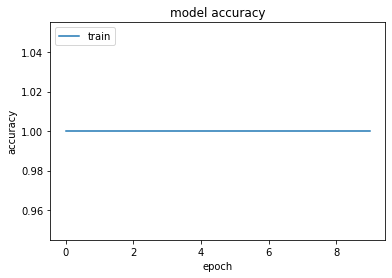

In [129]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

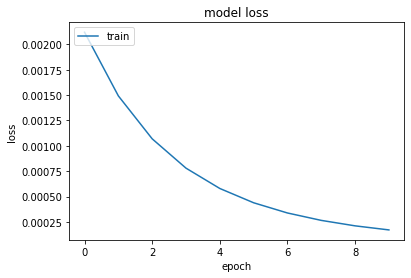

In [131]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#genderClf.fit(train_dataset, epochs=10, callbacks=[early_stopping_monitor], 
#              validation_split=0.25, batch_size=BATCH_SIZE)

In [122]:
genderClf.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10, 384)           49536     
_________________________________________________________________
dense_30 (Dense)             (None, 10, 128)           49280     
_________________________________________________________________
dense_31 (Dense)             (None, 10, 64)            8256      
_________________________________________________________________
dense_32 (Dense)             (None, 10, 1)             65        
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 1)              0         
Total params: 107,137
Trainable params: 107,137
Non-trainable params: 0
_________________________________________________________________


In [123]:
y_pred = genderClf.predict(x_test_embed)
#y_pred = genderClf.evaluate(test_dataset)
#y_pred = genderClf.predict(normalize(get_10s(spanish_raw, SAMP_RATE)))

In [124]:
#confusion_matrix(y_test_label, y_pred)
print(y_pred)

[[[0.9397265 ]]

 [[0.26224026]]]


# Next steps:
Embed the vggish model into a trainable binary classifier.

In [ ]:
# enable fine-tuning with trainable argument
#layer = hub.KerasLayer(..., trainable=True)

# Reexport the fine-tuned model

#loaded_obj = hub.load("https://tfhub.dev/...")
#hub_layer = hub.KerasLayer(loaded_obj, trainable=True, ...)

#model = keras.Sequential([..., hub_layer, ...])
#model.compile(...)
#model.fit(...)

#export_module_dir = os.path.join(os.getcwd(), "finetuned_model_export")
#tf.saved_model.save(loaded_obj, export_module_dir)

Epoch - on complete pass through the dataset

Batch size = divide dataset into smaller parts/sets

Iterations - number of batches to complete one epoch

In [ ]:
#model.fit(x, y, batch_size=n, epochs=n) # Batch size default is 32
# Do not use batch size if the data is in the form of dataset, generators, or keras.utils.Sequence instances

# Don't run this - sample code for later
## Import larger sample set
- at least two batches, to see how model fits
- a least one batch of testing data

## Original (small samples)

## Attempt to expand model

In [ ]:
meta.shape

(2134, 8)

In [ ]:
# Select 96 files at random from meta.filename
data = np.random.choice(meta.filename, size=96, replace=False)

idx = meta[meta.filename.isin(data)].index
df = meta.loc[idx, ['filename', 'sex']]

df.head()

,filename,sex
speakerid,,
1,afrikaans1,female
35,bengali2,female
54,danish1,female
86,english28,male
91,english32,female


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['filename'], df['sex'], random_state=38, test_size=0.33)

In [ ]:
train_dataset =  tf.data.Dataset.from_tensor_slices( (x_train, y_train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices( (x_test, y_test_labels))

In [ ]:
BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Convert data (np. arrays) to a TF Dataset